# Plotting NUCAPS profiles with Python

Author: Rebekah Esmaili, Science and Technology Corportation, rebekah@stcnet.com

[NUCAPS](https://weather.msfc.nasa.gov/nucaps/) satellite soundings retrieves tempterature and trace gases in three dimensions. Suomi NPP and NOAA-20 NUCAPS data can be ordered from [NOAA/CLASS](https://www.bou.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=JPSS_SND&submit.x=21&submit.y=10).

This Jupyter Notebook contains Python 3 code that will find the closest NUCAPS footprint (which are 50 at nadir 150 km near the scan edge) to a given point and make a profile of temperature, water vapor, and ozone. The code below will search a list of files and use the swath geometry to determine if the point is inside the file. Then, it will open the netCDF files and use a nearest neighbors search to find the closest footprint. Feel free to customize this code to explore different trace gases and ranges.

Below, we import some important packages. All of these packages are included in the [Anaconda Platform](https://www.anaconda.com/distribution/), which we recommend installing to run this notebook.

In [1]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mplPath
from sklearn.neighbors import NearestNeighbors

## Define a coordinate to search for and a specific date
Below we enter the point that we want to search for, along with the date (leave blank to search all files) and the directory that contains the netCDF files.

In [2]:
# Enter point - [lon, lat]
point = [-82.5,  34.0]

# YYYYMMDD - or leave blank for all files in directory
date = '20181011'

# Data directory
data_dir = "npp_data/"

## Searching all files to find which ones contain the point
We will next define the **nearest_file** function extracts the swath from the geospatial_bounds global attribute in the NUCAPS netCDF file. It will then parse this string to exract the coordinates to define a path that will will make an outline of the swath shape. If the given point is within the swath, it will return True. If not, it will return False.

In [3]:
def nearest_file(file, point):
    str_bounds = xr.open_dataset(file, decode_times=False).geospatial_bounds
    point_list=[]
    for str_coords in str_bounds[9:].split(','):
        str_coord = str_coords.replace("))","").split(' ')
        point_list.append([float(str_coord[-2]), float(str_coord[-1])])

    bbPath = mplPath.Path(np.array(point_list))
    in_file = bbPath.contains_point((point[0], point[1]))
    
    return in_file

We have now defined our the point/date of interest and created helpful function to search our files. Now we can import our list of files and check each one to see if any contain our point:

In [4]:
files = glob(data_dir+"*"+date+"*.nc")
in_filelist = [nearest_file(file, point) for file in files]

in_filelist is a list of True/False values. We can use this list to mask out the files that we will not use from the filelist. If there's at least one match, we will open this file. In this example, there are two files that contain the point. From inspecting the filenames (look for the _s, and the numbers that follow are YYYYMMDDHHMM) on the im AM (07 UTC) and one in the PM (18 UTC). If you only wish to consider the afternoon orbit, return to the top of the notebook and update the "date" variable (date = '20181011') to include the hour as well (date = '2018101118'). Then, re-run all the cells in the notebook. This will limit the search and the output below will only have one file listed.

In [5]:
files_nearest = np.array(files)[in_filelist]
if len(files_nearest) > 0:
    print(files_nearest)

['npp_data/NUCAPS-EDR_v2r0_npp_s201810111831430_e201810111832130_c201810111917220.nc']


## Find the closest profile to the point
We use a nearest neighbor technique from the sklearn package, which we define in the neigh variable. It will find all points within 0.4 gridpoints from the given point. Increasing this threshold will increase the number of matches, while decreasing will minimize them. The samples variable organizes the NUCAPS latitude and longitude values for each footprint (a dimension called Number_of_CrIS_FORs) in the netCDF file. neigh.fit(samples) defined the fitting function while the variable matches find the return list of closest footprint points. The last line checks if any matches were found. 

In [6]:
# Open all datasets that contain the closest point
nucaps = xr.open_mfdataset(files_nearest, decode_times=False)

# Return index of closest point
neigh = NearestNeighbors(radius=0.4)

samples = [[nucaps.Longitude.values[i], nucaps.Latitude.values[i]] for i in nucaps.Number_of_CrIS_FORs.values]
neigh.fit(samples)
matches = neigh.radius_neighbors([point])

if len(matches[0][0]) == 0:
    print("No matches found.")

The code block below extracts the indices which lists the footprints that are closest to the point and their distance from the point. We want to narrow down to the closest point (in space), so we use distance.min() to select this values.

In [7]:
indices = matches[1][0]
distance = matches[0][0]
index = indices[distance == distance.min()]

## Importing cloud retrieval, formatting time, and plot aetsthetics
The units of time in NUCAPS are miliseconds, so they must be converted to seconds for xarray to properly interpret them. This will improve the title on the plot.

In [8]:
# Fix time units
nucaps0 = nucaps.sel(Number_of_CrIS_FORs=index)
nucaps0['Time']=nucaps0['Time']/1000.0
nucaps0.Time.attrs = {'units': 'seconds since 1970-01-01'}
nucaps0 = xr.decode_cf(nucaps0)

Next, we extract the cloud information from the **Cloud_Top_Pressure** and **Cloud_Top_Fraction** variables. This step is optional, but it can be useful to know the cloud fraction and the cloud top pressure when looking at the profiles.

In [9]:
# Find the cloud levels and fraction
cloud_level_0 = nucaps0.sel(Number_of_Cloud_Layers=0)
cloud_pressure = cloud_level_0.Cloud_Top_Pressure.values[0]
cloud_frac = round(cloud_level_0.Cloud_Top_Fraction.values[0], 2)

The next three functions (nice_lat_lon, make_nice_title, and nice_units) are for aesthetics are not required. nice_lat_lon will reformat the float latitude coordinates to shown N/S and float longitude to show E/W. nice_title includes the satellite platform, time, and coordinate to make the profile easier to compare with others. This will also indicate if the profile is REJECTED if did not pass quality control. The nice_units function converts the units=1 in the netCDF file to descriptive units. Altogether, these functions help improve the readability of the plot without cluttering the plotting code at the end.

In [10]:
def nice_lat_lon(lat, lon):
    lon = round(lon)
    if lon < 0:
        lon_str = str(np.abs(lon)) + r'$45\degree$W'
    else:
        lon_str = str(lon) + r'$45\degree$E'
    
    lat = round(lat)
    if lat < 0:
        lat_str = str(np.abs(lat)) + r'$45\degree$S'
    else:
        lat_str = str(lat) + r'$45\degree$N'
                      
    return lat_str+', '+lon_str

def make_nice_title(df):
    lat = df.Latitude.values[0]
    lon = df.Longitude.values[0]
    nice_lat_lon_str = nice_lat_lon(lat, lon)
    str_time = str(df.Time.values[0])[:16]

    qf = df.Quality_Flag.values[0]
    qf_str = ''
    if (qf > 0):
        qf_str = ' REJECTED'

    title = 'NUCAPS-' + df.platform_name + ' '
    title = title + str_time.replace('T', ' ')+' UTC at:'
    title = title + ' ' + nice_lat_lon_str + qf_str

    fname='NUCAPS_'+df.platform_name+'_t'+str_time+'_y'+str(lat)+'_x'+str(lon)+qf_str+'.png'
    return title, fname

def nice_units(df, var):
    units = df[var].units
    if units == '1':
        units = 'molecules/'+'$\mathregular{cm^2}$'
        
    return units

We also update the default figure and font sizes (plt.rcParams) to make the figures easier to read. 

In [11]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 18})

## Plotting the profile
Finally, we plot profiles for three variables: **Temperature**, **H2O**, and **O3**. We've define the x and y ranges in the code below, so feel free to update these to customize the plot. The plots will also add a horizontal line to show the cloud top pressure level (if the cloud top fraction is above 10%) and annotate with cloud top fraction. This can help put context to rejected retrievals.

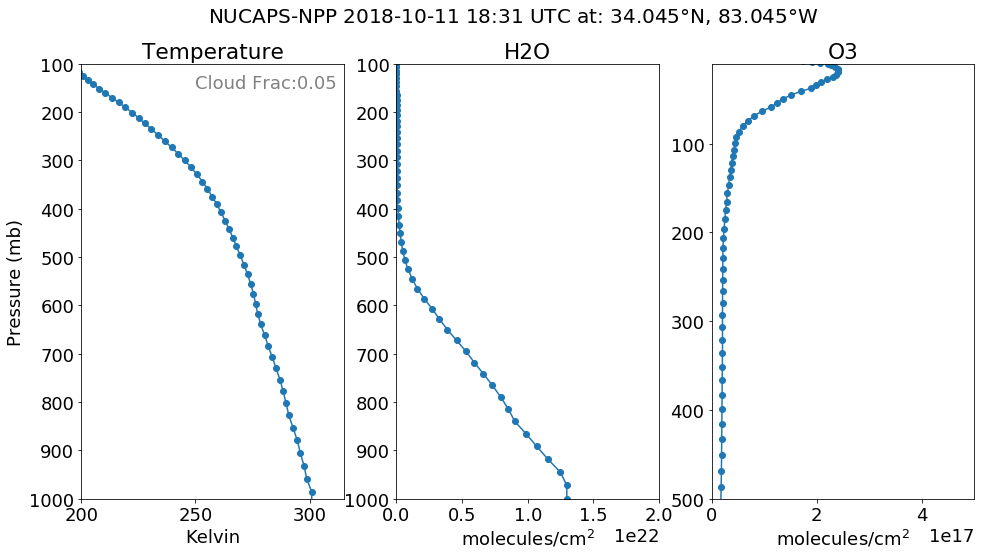

In [12]:
title, fname =  make_nice_title(nucaps0)

fig = plt.figure()
fig.suptitle(title, fontsize=20)
for i, var in enumerate(['Temperature', 'H2O', 'O3']):
    ax = plt.subplot(1, 3, i+1)
    ax.invert_yaxis()
    ax.set_ylim(1000, 100)
    if cloud_frac >= 0.1:
        ax.axhline(y=cloud_pressure, color='grey', linestyle='--')

    x = nucaps0[var][0]  
    if var == 'Temperature':
        y = nucaps0['Pressure'][0]
        ax.plot(x, y, '-o')
        ax.set_ylabel("Pressure (mb)")
        # Cloud fraction
        ax.annotate('Cloud Frac:'+str(cloud_frac), (250, 150), color='grey')
        # Control y,x limits
        ax.set_xlim(200, 315)
    else:
        y = nucaps0['Effective_Pressure'][0]
        ax.plot(x, y, '-o')
        
        # Control x, y limits
        if var == 'O3':
            ax.set_ylim(500, 10)
            ax.set_xlim(0, 5e17)
        if var == 'H2O':
            ax.set_xlim(0, 2e22)
        
    ax.set_title(var)
    ax.set_xlabel(nice_units(nucaps0, var))

plt.show()

To save the plots, you can either right click and select 'save as.' Alternatively, you can save the plots in non-interactive mode. The plots will not display but will instead be saved to file. To do this, remove:
```
plt.show()
```
and instead add:
```
plt.savefig(fname)
plt.close()
```
You can provide any name you wish, but the fname will provide a nicely formatted filename that contains the satellite, time, and location of the profiles.
